# Single-Task Learning on Cifar10 Dataset - Super-Class Classfication: A Vision Transformer Approach
- **Name**: Minh T. Nguyen & Peter Chen.
- **ECE 6524** - Final Project.
- **Date**: 4/22/2023.
- **Objective**: Build a Single Task model for image classification on Cifar10.

### References:
- Paper: ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929).
- [Author's Github Repository](https://github.com/google-research/vision_transformer).
- [Keras' Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

### Vision Transformers Architecture Explanation
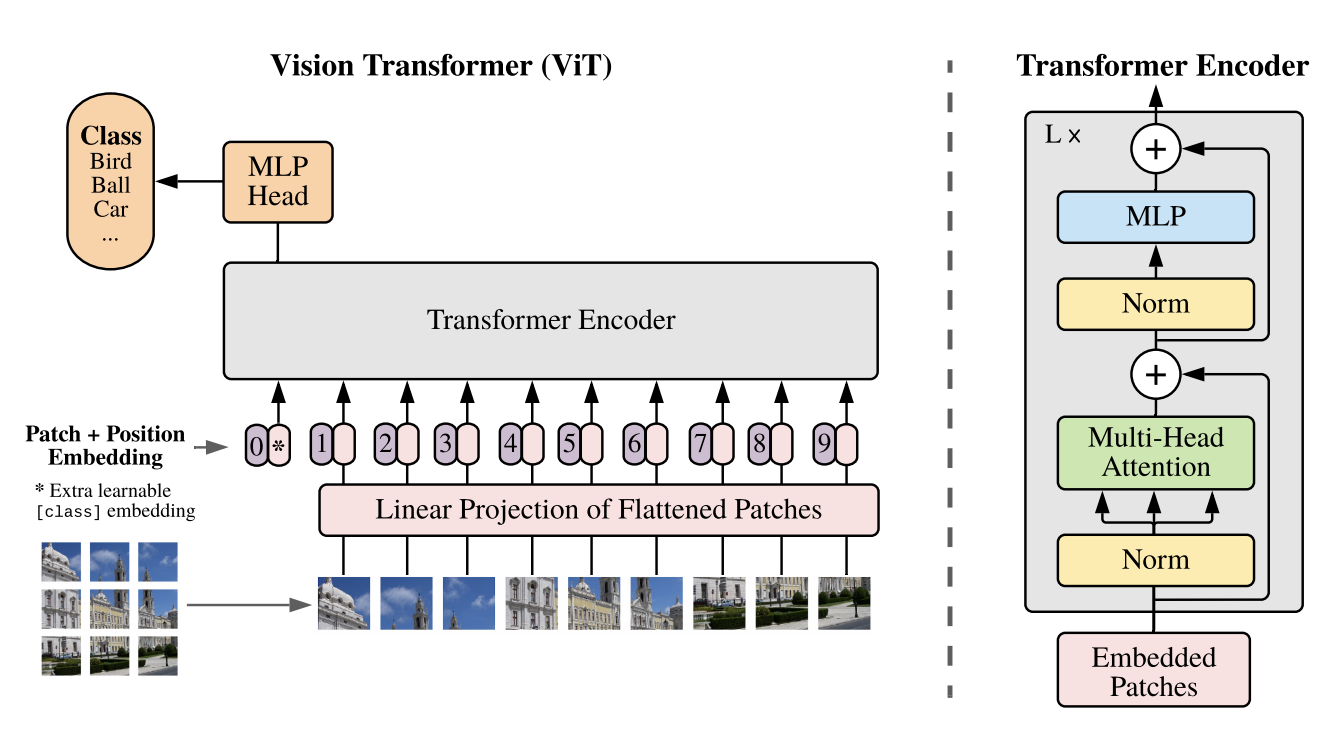

- **About**: Visions tasks were dominated by CNN-based architecture. However, Vision Transformers (ViT) has showed to be a high-capacity network architecture and can outperform CNN-based network on vision Tasks.
- **ViT Architecture**:
    - **Pipeline**: ViT computes the attentions between patches instead of image pixels due to limitation in computational power. **Input > Linear Projection > Stacked Encoder > MLP > Output Labels**
    - **Input Processing**: 
        - Convert Image to Patches.
        - Linear Projection: Each patch is reshaped to 1D vector, then we multiple with a learnable matrix to create a vector (patch linear projection). By doing for all patches, we will get an image linear projection.
        - Position Embedding: ViT is invariant to position on patches. For CNN, convolution is translation and scale equivariant (important for object detection) while pooling is translation and scale invariant (important for image recognition). By combining convolution and pooling, CNN can deal with recognition, object detection, and segmentation. Position embedding allow ViT to behave like CNN. This is the only inductive bias in ViT.  
    - **Transformers Encoder - Self-attention + MLP**:
        - Why do we have Layer Normalization? To reduce training time and stabilizes training phases.
        - Why do we use Skip Connection? To improves the performance by as much as 4% on recognition by propagating representation across layers.
        - Why do we use Multi-Head Self-Attention? To learn different representation of self-attention matrix to boost performance.
    - **MLP + Output**: Prediction outputs.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras import layers
from keras.utils import np_utils, plot_model

# 1. Data Visualization & Preprocessing

In [2]:
num_classes = 10          # number of classes
input_shape = (32, 32, 3) # original input image size
num_super_classes = 2     # number of super-classes

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


**Note**: Let's check for unique values in [Cifar website](https://www.cs.toronto.edu/~kriz/cifar.html), we got:
- 0 = airplane.
- 1 = automobile.
- 2 = bird.
- 3 = cat.
- 4 = deer.
- 5 = dog.
- 6 = frog.
- 7 = horse.
- 8 = ship.
- 9 = truck.

Thus, animal will be [2, 3, 4, 5, 6, 7] and vehicle will be [0, 1, 8, 9]

In [5]:
# check unique values
print(f"The unique values in the list is: {np.unique(np.array(y_train))}.")
print(f"The unique values in the list is: {np.unique(np.array(y_test))}.")

The unique values in the list is: [0 1 2 3 4 5 6 7 8 9].
The unique values in the list is: [0 1 2 3 4 5 6 7 8 9].


## 1.1. Data Visualization

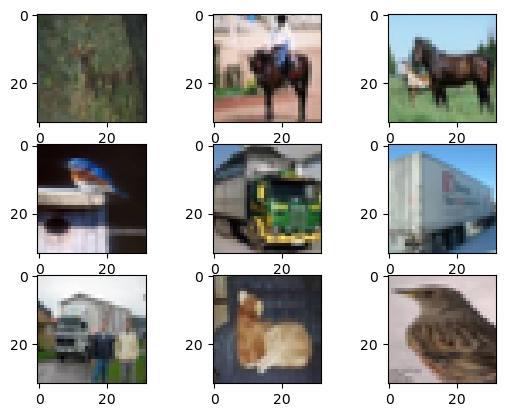

In [6]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Superclass Generation

In [7]:
def generate_superclass_label(y_train, y_test, animal_classes):
    """
    Generate a binary super class of Animal and Vehicles
    @Parameters:
    - y_train: list of labels of the training dataset.
    - y_test: list of the labels of the testinig dataset.
    """
    y_train_super = [0 if y in animal_classes else 1 for y in y_train ] 
    y_test_super = [0 if y in animal_classes else 1 for y in y_test]
    
    return y_train_super, y_test_super

In [8]:
# generate labels for the super-classes
y_train_super, y_test_super = generate_superclass_label(
    y_train=y_train,
    y_test=y_test,
    animal_classes=[2, 3, 4, 5, 6, 7] # bird, cat, deer, dog, frog, horse
)

In [9]:
# check shape
print(f"The new training dataset has the shape of {len(y_train_super)}.")
print(f"The new testing dataset has the shape of {len(y_test_super)}.")

The new training dataset has the shape of 50000.
The new testing dataset has the shape of 10000.


In [10]:
# convert to numpy array and extend dimension
y_train_super = np.expand_dims(np.array(y_train_super), axis=1)
y_test_super = np.expand_dims(np.array(y_test_super), axis=1)

In [11]:
# check shape
print(f"X={X_train.shape}, y={y_train_super.shape}")
print(f"X={X_test.shape}, y={y_test_super.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


In [12]:
# check unique values
print(f"The unique values in the list is: {np.unique(np.array(y_train_super))}.")
print(f"The unique values in the list is: {np.unique(np.array(y_test_super))}.")

The unique values in the list is: [0 1].
The unique values in the list is: [0 1].


In [13]:
# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super, num_super_classes)
y_test_super = np_utils.to_categorical(y_test_super, num_super_classes)

In [14]:
# check shape
print(f"X={X_train.shape}, y={y_train_super.shape}")
print(f"X={X_test.shape}, y={y_test_super.shape}")

X=(50000, 32, 32, 3), y=(50000, 2)
X=(10000, 32, 32, 3), y=(10000, 2)


## 1.3. Data Augmentation

In [15]:
# set images parameters
image_size = 72                                # resize image from 32x32x3 to 72x72x3
patch_size = 6                                 # each image will be divided into patch with each patches has size of 6x6
num_patches = (image_size // patch_size) ** 2  # total number of patches in an image

In [16]:
print(f"The total number of patches in an splitted image is {num_patches}.")

The total number of patches in an splitted image is 144.


In [17]:
# create a data augmentation layer
data_aug = keras.Sequential(
    [
        layers.Normalization(),                  # normalize image
        layers.Resizing(image_size, image_size), # resize image from 32x32x3 to 72x72x3
    ],
    name="data_augmentation",
)

# compute the mean and varaince of the training data for normalization
data_aug.layers[0].adapt(X_train)

## 1.4. Patch Transformation
**Note**: Convert an input image into a patch-dimension. The class Patch's job is to transform image to patch-dimension. For instance, with our input image as **(1, 72, 72, 3)** = (1 image, 72 width pixel, 72 height pixel, 3 color channel), the output will be **(1, 12, 12, 108)** = (1 image, 12 width patch, 12 height patch, 108 depth).

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        """Constructor"""
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        """Forward-pass function"""
        batch_size = tf.shape(images)[0]
        
        # pixel to patch conversion
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        
        # get depth
        patch_dims = patches.shape[-1]
        
        # resize
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Note**: Let's go through an example

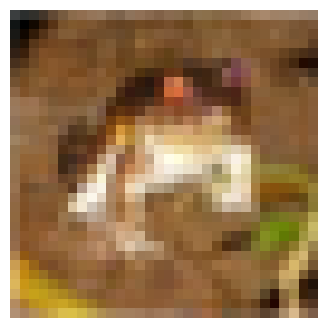

In [19]:
# plot original image
plt.figure(figsize=(4,4))
image = X_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

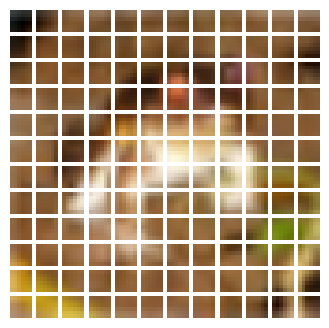

In [20]:
# resize and patch the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

# get number of patch width (or height)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

# patch the image and visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Note**: Let's get some calculated patches results after the transformation

In [21]:
print(f"Original image size: {image_size} x {image_size}.")
print(f"Calculated patch size: {patch_size} x {patch_size}.")
print(f"Number of patches per image: {patches.shape[1]}.")
print(f"Depth size of each patch: {patches.shape[-1]}.")

Original image size: 72 x 72.
Calculated patch size: 6 x 6.
Number of patches per image: 144.
Depth size of each patch: 108.


# 2. Modeling
**Note**: Build a Patch Encoding Layer and Build a Vision Transformers architecture.

In [22]:
# the size of the project dimension is just how depth the PatchEncoder layer prior to fetch to the Transformers
projection_dim = 64 

## 2.1. Patch Encoding Layer
**Note**: We will fetch each patch through a "Linear Projection of Flatten Patches" (aka, transform dimension via Dense layer) and attached the learnable Positional Embedding layer.

**Note**: Let's first visualize the positional embedding matrix. Each number is the position of each patch.

In [23]:
print(tf.range(start=0, limit=144, delta=1))

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143], shape=(144,), dtype=int32)


In [24]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """Constructor"""
        super().__init__()
        self.num_patches = num_patches                       # (12 x 12) = 144 patches
        self.projection = layers.Dense(units=projection_dim) # Dense layer that map the patched input to the projection_dim
        self.position_embedding = layers.Embedding(          # learnable embedding layer for the position (above)
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        """Forward Pass"""
        # create a position matrix
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        # resize the input patch with Dense
        input_patch = self.projection(patch)
        
        # encode position array with learnable embedding layer
        pos_emb = self.position_embedding(positions)
        
        # patch + position embedding
        encoded_patch = input_patch + pos_emb
        
        return encoded_patch

## 2.2. Vision Transformers
**Note**: Input > Linear Projection > Stacked Encoder > MLP > Output Labels

In [25]:
# training settings
batch_size = 256          # number of images per batch
num_heads = 4             # nummber of attention heads in the multi-attention layer
num_epochs = 10           # number of training epochs
transformer_dropout = 0.2 # dropout rate of mlp inner of transformers
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# transformers settings
transformer_layers = 8    # number of stacked encoder layers

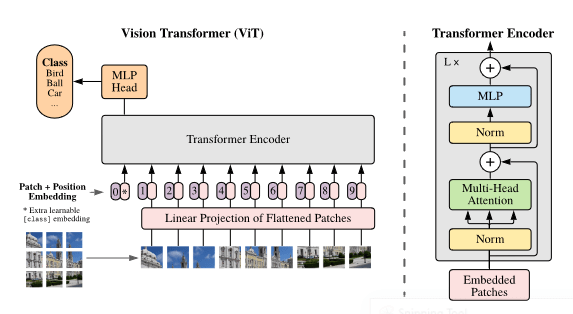

In [26]:
def create_model(mlp_dropout):
    # set input layer
    inputs = layers.Input(shape=input_shape)

    # normalize and resize image
    augmented = data_aug(inputs)

    # convert image's pixels into patches
    patches = Patches(patch_size)(augmented)

    # encode patch by linearly transform patch with dense and add the learnable position encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # create stacked encoder
    for _ in range(transformer_layers):
        # layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # multi-head attention
        mtha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # skip connection 1 = add input with mtha
        x2 = layers.Add()([mtha, encoded_patches])

        # layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x4 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x4 = layers.Dropout(transformer_dropout)(x4)
        x4 = layers.Dense(projection_dim, activation=tf.nn.gelu)(x4)
        x4 = layers.Dropout(transformer_dropout)(x4)

        # skip connection 2
        encoded_patches = layers.Add()([x4, x2])

    # flatten transformers
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(mlp_dropout)(representation)
    features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(512, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(256, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(128, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    output = layers.Dense(num_super_classes, activation='softmax')(features)
    
    # create model
    model = keras.Model(inputs=inputs, outputs=output)
    
    return model

In [27]:
# create a model
model = create_model(mlp_dropout=mlp_dropout)

In [28]:
# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

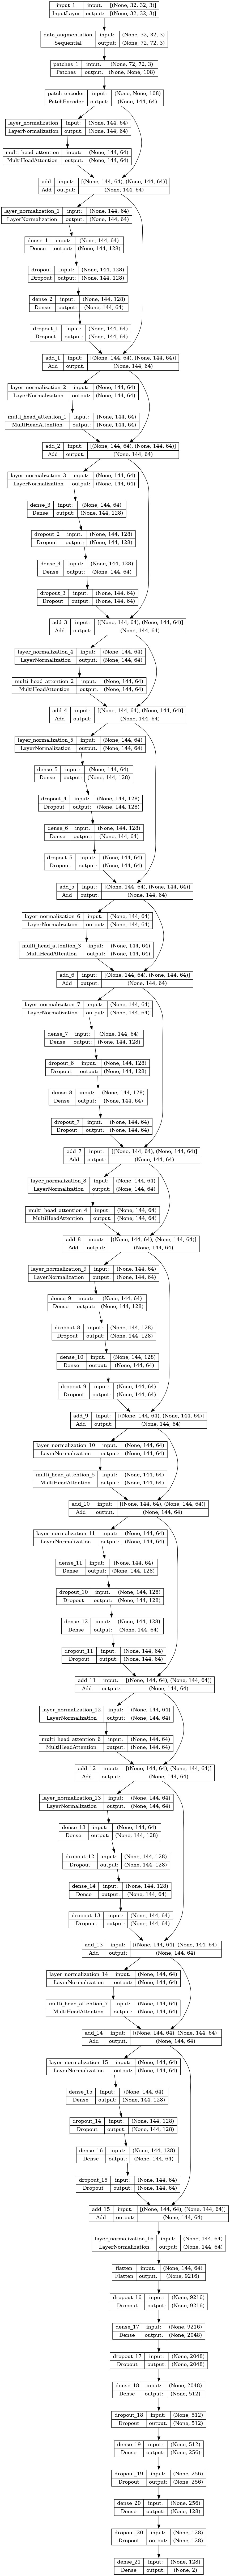

In [29]:
# plot architectures
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 2.3. Compile Model

In [30]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 2.4. Train & Validate Model

In [31]:
# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

In [32]:
# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
167/167 [==============================] - 96s 366ms/step - loss: 0.3934 - accuracy: 0.8451 - val_loss: 0.4202 - val_accuracy: 0.8325
Epoch 2/10
167/167 [==============================] - 63s 376ms/step - loss: 0.2431 - accuracy: 0.9030 - val_loss: 0.2160 - val_accuracy: 0.9119
Epoch 3/10
167/167 [==============================] - 64s 382ms/step - loss: 0.1868 - accuracy: 0.9261 - val_loss: 0.3864 - val_accuracy: 0.8459
Epoch 4/10
167/167 [==============================] - 64s 383ms/step - loss: 0.1712 - accuracy: 0.9320 - val_loss: 0.2293 - val_accuracy: 0.9135
Epoch 5/10
167/167 [==============================] - 63s 380ms/step - loss: 0.1212 - accuracy: 0.9533 - val_loss: 0.2084 - val_accuracy: 0.9257
Epoch 6/10
167/167 [==============================] - 64s 383ms/step - loss: 0.0834 - accuracy: 0.9675 - val_loss: 0.2620 - val_accuracy: 0.9196
Epoch 7/10
167/167 [==============================] - 62s 374ms/step - loss: 0.0605 - accuracy: 0.9778 - val_loss: 0.3538 - val_ac

In [33]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

Train loss: 0.0741577073931694
Train acc: 0.9714353084564209


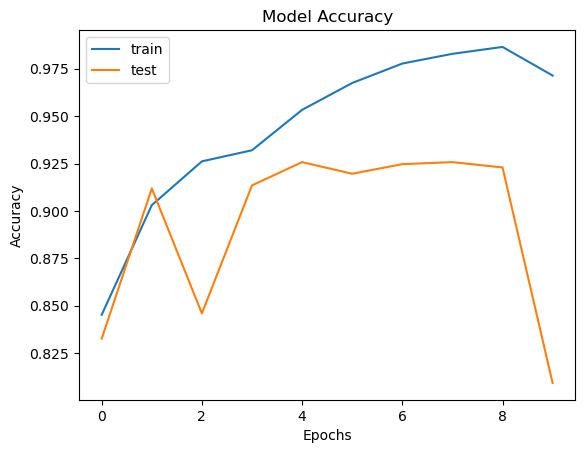

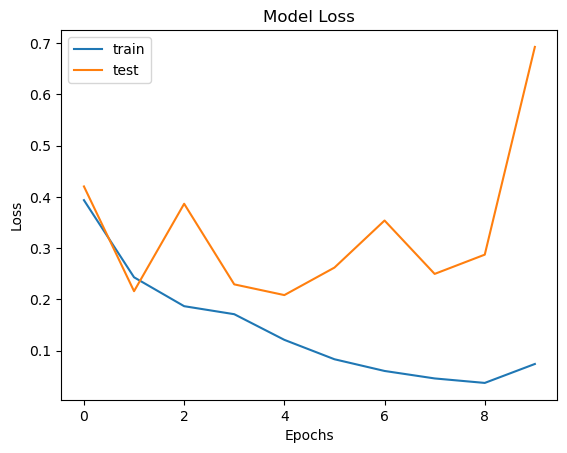

In [34]:
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.5. Test Trained Model

In [35]:
# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.6754560470581055
Test acc: 0.8105999827384949


# 3. Optimize ViT with Different Parameters

## 3.1. Case 1  - Batch Size = 256, Dropout-MLP=0, Adam Optimizer (Trained Aboved)

In [36]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

Train loss: 0.0741577073931694
Train acc: 0.9714353084564209


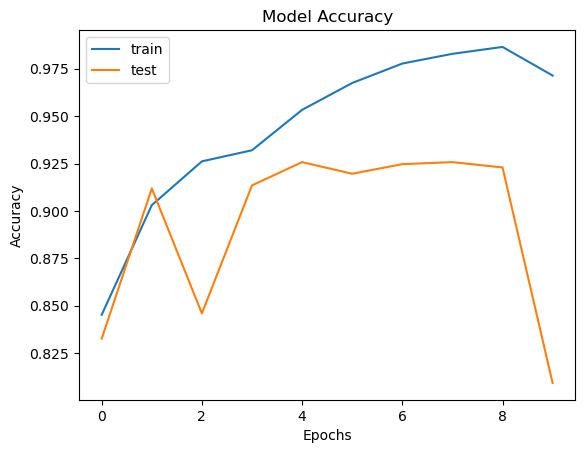

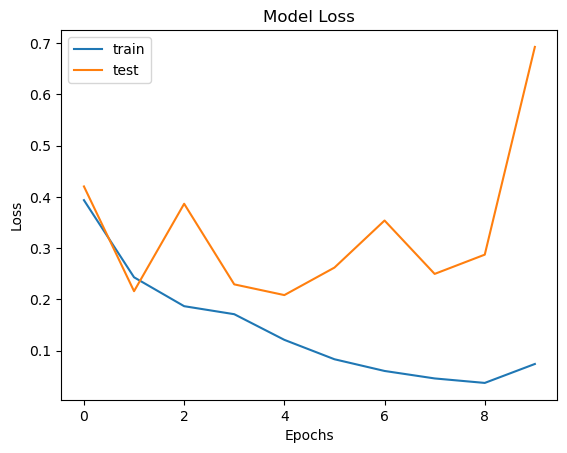

In [37]:
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.6754560470581055
Test acc: 0.8105999827384949


## 3.2. Case 2  - Batch Size = 128, Dropout-MLP=0, Adam Optimizer

Epoch 1/10
333/333 [==============================] - 99s 206ms/step - loss: 0.3208 - accuracy: 0.8722 - val_loss: 0.2319 - val_accuracy: 0.9084
Epoch 2/10
333/333 [==============================] - 67s 202ms/step - loss: 0.2053 - accuracy: 0.9195 - val_loss: 0.3487 - val_accuracy: 0.8611
Epoch 3/10
333/333 [==============================] - 68s 205ms/step - loss: 0.1790 - accuracy: 0.9299 - val_loss: 0.2103 - val_accuracy: 0.9197
Epoch 4/10
333/333 [==============================] - 68s 205ms/step - loss: 0.1418 - accuracy: 0.9457 - val_loss: 0.2063 - val_accuracy: 0.9244
Epoch 5/10
333/333 [==============================] - 68s 205ms/step - loss: 0.0997 - accuracy: 0.9629 - val_loss: 0.1921 - val_accuracy: 0.9328
Epoch 6/10
333/333 [==============================] - 67s 201ms/step - loss: 0.0708 - accuracy: 0.9735 - val_loss: 0.3314 - val_accuracy: 0.9031
Epoch 7/10
333/333 [==============================] - 67s 201ms/step - loss: 0.0623 - accuracy: 0.9770 - val_loss: 0.3182 - val_ac

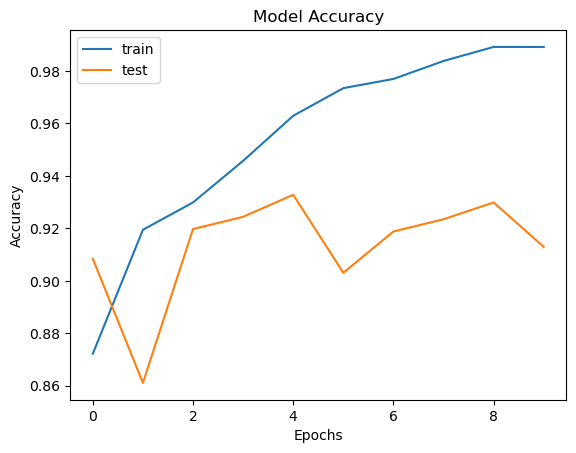

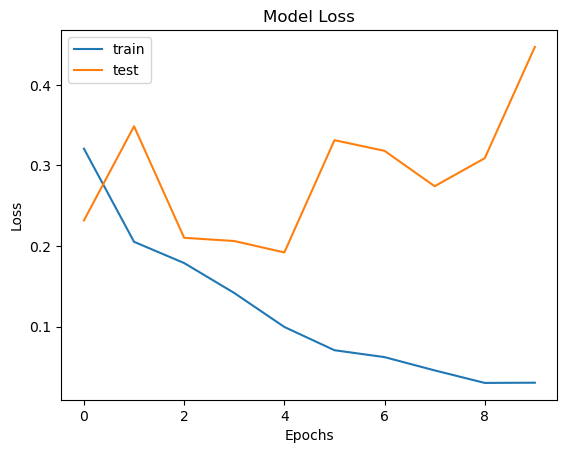

Test loss: 0.4488828480243683
Test acc: 0.9118000268936157


In [39]:
# training settings
batch_size = 128          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.3. Case 3  - Batch Size = 256, Dropout-MLP=0.5, Adam Optimizer

Epoch 1/10
167/167 [==============================] - 92s 372ms/step - loss: 0.5868 - accuracy: 0.7623 - val_loss: 0.3481 - val_accuracy: 0.8547
Epoch 2/10
167/167 [==============================] - 63s 378ms/step - loss: 0.3197 - accuracy: 0.8738 - val_loss: 0.2892 - val_accuracy: 0.8669
Epoch 3/10
167/167 [==============================] - 62s 371ms/step - loss: 0.2577 - accuracy: 0.9000 - val_loss: 0.2860 - val_accuracy: 0.8673
Epoch 4/10
167/167 [==============================] - 62s 374ms/step - loss: 0.2551 - accuracy: 0.9005 - val_loss: 0.1966 - val_accuracy: 0.9196
Epoch 5/10
167/167 [==============================] - 63s 379ms/step - loss: 0.2125 - accuracy: 0.9187 - val_loss: 0.1984 - val_accuracy: 0.9213
Epoch 6/10
167/167 [==============================] - 65s 387ms/step - loss: 0.2127 - accuracy: 0.9195 - val_loss: 0.1838 - val_accuracy: 0.9249
Epoch 7/10
167/167 [==============================] - 63s 380ms/step - loss: 0.1941 - accuracy: 0.9273 - val_loss: 0.1898 - val_ac

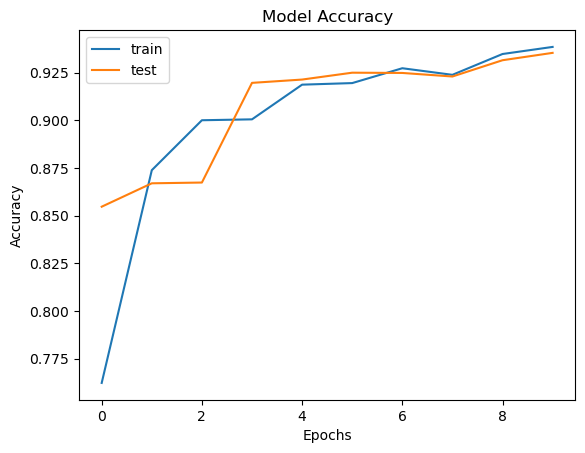

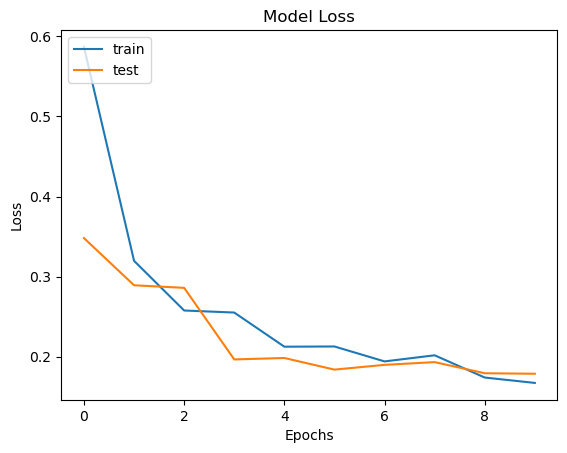

Test loss: 0.17946861684322357
Test acc: 0.9333999752998352


In [40]:
# training settings
batch_size = 256            # number of images per batch
mlp_dropout = 0.5           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.4. Case 4  - Batch Size = 256, Dropout-MLP=0, SGD Optimizer

Epoch 1/10
167/167 [==============================] - 80s 376ms/step - loss: 0.4177 - accuracy: 0.8113 - val_loss: 0.6901 - val_accuracy: 0.7764
Epoch 2/10
167/167 [==============================] - 63s 375ms/step - loss: 0.3459 - accuracy: 0.8534 - val_loss: 1.6421 - val_accuracy: 0.4936
Epoch 3/10
167/167 [==============================] - 64s 382ms/step - loss: 0.3272 - accuracy: 0.8625 - val_loss: 0.3510 - val_accuracy: 0.8627
Epoch 4/10
167/167 [==============================] - 63s 378ms/step - loss: 0.2917 - accuracy: 0.8781 - val_loss: 0.9635 - val_accuracy: 0.7667
Epoch 5/10
167/167 [==============================] - 64s 384ms/step - loss: 0.2799 - accuracy: 0.8850 - val_loss: 0.2872 - val_accuracy: 0.8861
Epoch 6/10
167/167 [==============================] - 63s 379ms/step - loss: 0.2600 - accuracy: 0.8928 - val_loss: 0.3625 - val_accuracy: 0.8675
Epoch 7/10
167/167 [==============================] - 63s 379ms/step - loss: 0.2454 - accuracy: 0.8992 - val_loss: 0.6833 - val_ac

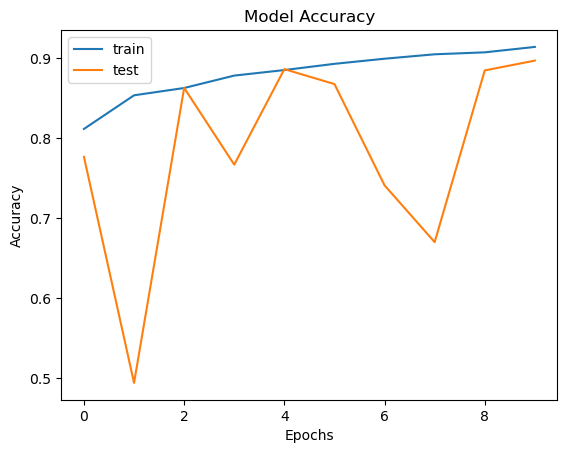

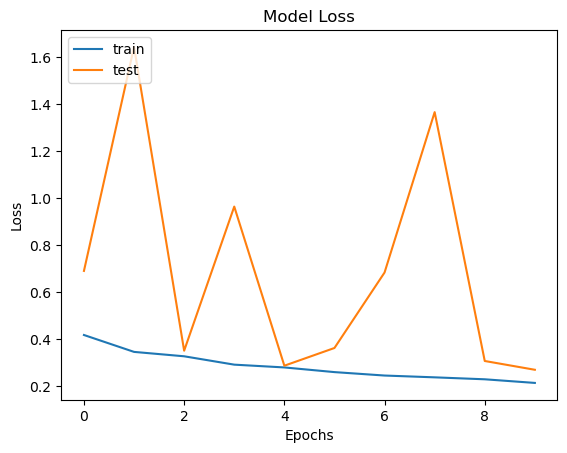

Test loss: 0.25843876600265503
Test acc: 0.8960000276565552


In [41]:
# training settings
batch_size = 256          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.5. Case 5  - Batch Size = 128, Dropout-MLP=0, SGD Optimizer

Epoch 1/10
333/333 [==============================] - 82s 202ms/step - loss: 0.3906 - accuracy: 0.8277 - val_loss: 0.3463 - val_accuracy: 0.8596
Epoch 2/10
333/333 [==============================] - 64s 192ms/step - loss: 0.3119 - accuracy: 0.8697 - val_loss: 0.6195 - val_accuracy: 0.8028
Epoch 3/10
333/333 [==============================] - 65s 194ms/step - loss: 0.2746 - accuracy: 0.8877 - val_loss: 0.4794 - val_accuracy: 0.8296
Epoch 4/10
333/333 [==============================] - 67s 201ms/step - loss: 0.2487 - accuracy: 0.8970 - val_loss: 0.2824 - val_accuracy: 0.8949
Epoch 5/10
333/333 [==============================] - 66s 199ms/step - loss: 0.2276 - accuracy: 0.9066 - val_loss: 0.3155 - val_accuracy: 0.8871
Epoch 6/10
333/333 [==============================] - 66s 199ms/step - loss: 0.2102 - accuracy: 0.9141 - val_loss: 0.7234 - val_accuracy: 0.8147
Epoch 7/10
333/333 [==============================] - 66s 198ms/step - loss: 0.1982 - accuracy: 0.9207 - val_loss: 0.2473 - val_ac

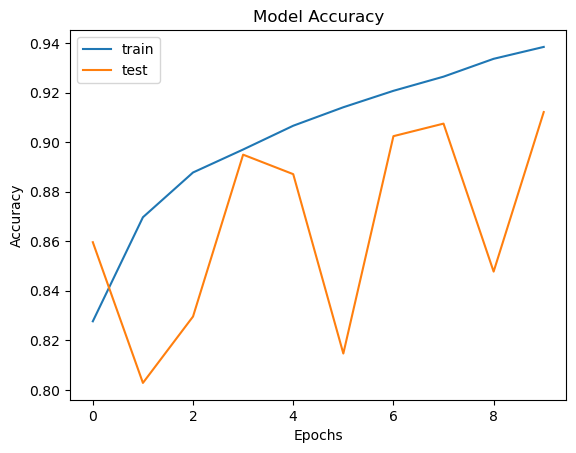

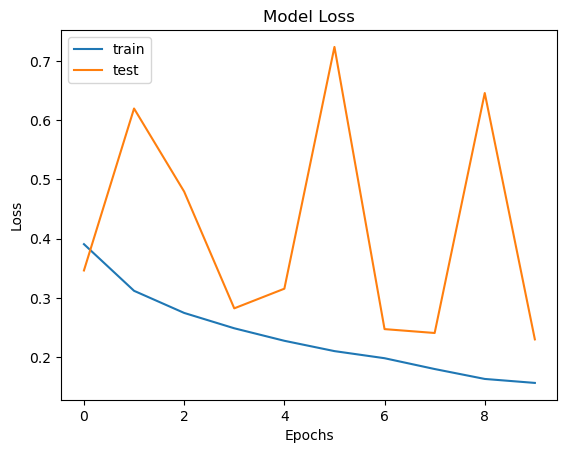

Test loss: 0.21776174008846283
Test acc: 0.9124000072479248


In [42]:
# training settings
batch_size = 128          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.6. Case 6  - Batch Size = 256, Dropout-MLP=0.5, SGD Optimizer

Epoch 1/10
167/167 [==============================] - 81s 390ms/step - loss: 0.7894 - accuracy: 0.6581 - val_loss: 0.4821 - val_accuracy: 0.7883
Epoch 2/10
167/167 [==============================] - 65s 387ms/step - loss: 0.5427 - accuracy: 0.7431 - val_loss: 0.4639 - val_accuracy: 0.7980
Epoch 3/10
167/167 [==============================] - 64s 386ms/step - loss: 0.5028 - accuracy: 0.7686 - val_loss: 0.4496 - val_accuracy: 0.7980
Epoch 4/10
167/167 [==============================] - 63s 378ms/step - loss: 0.4753 - accuracy: 0.7853 - val_loss: 0.4278 - val_accuracy: 0.8081
Epoch 5/10
167/167 [==============================] - 64s 386ms/step - loss: 0.4579 - accuracy: 0.7944 - val_loss: 0.4193 - val_accuracy: 0.8153
Epoch 6/10
167/167 [==============================] - 65s 386ms/step - loss: 0.4495 - accuracy: 0.8015 - val_loss: 0.4154 - val_accuracy: 0.8187
Epoch 7/10
167/167 [==============================] - 63s 377ms/step - loss: 0.4407 - accuracy: 0.8057 - val_loss: 0.3953 - val_ac

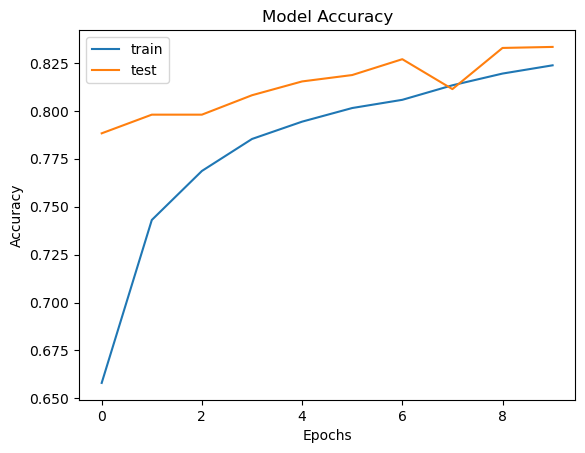

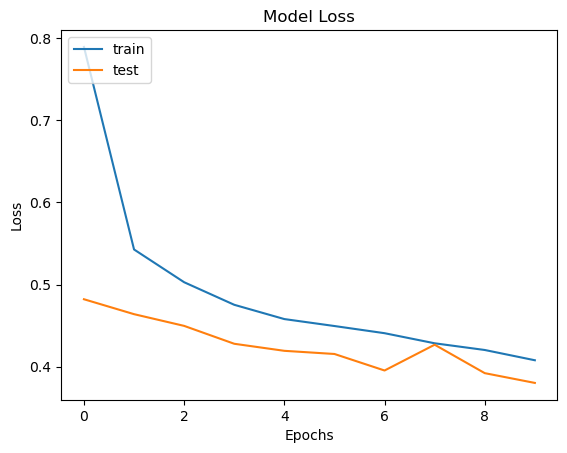

Test loss: 0.3752295970916748
Test acc: 0.8384000062942505


In [43]:
# training settings
batch_size = 256            # number of images per batch
mlp_dropout = 0.5           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)